<a href="https://colab.research.google.com/github/chin0104/DPDM2023/blob/main/00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np

Mounted at /content/drive


#import data

In [2]:
np.random.seed(seed=1)

In [3]:
CD = pd.read_excel('/content/drive/MyDrive/DPDM2021_DATA/creditTT1000.xlsx')

In [4]:
CD.head()

,age,income,home_ownership,emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
CD = CD.replace({'N':0,'Y':1})

In [6]:
CD.shape

(1000, 12)

#Data Preparation

In [7]:
CD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         1000 non-null   int64  
 1   income                      1000 non-null   int64  
 2   home_ownership              1000 non-null   object 
 3   emp_length                  970 non-null    float64
 4   loan_intent                 1000 non-null   object 
 5   loan_grade                  1000 non-null   object 
 6   loan_amnt                   1000 non-null   int64  
 7   loan_int_rate               898 non-null    float64
 8   loan_status                 1000 non-null   int64  
 9   loan_percent_income         1000 non-null   float64
 10  cb_person_default_on_file   1000 non-null   int64  
 11  cb_person_cred_hist_length  1000 non-null   int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 93.9+ KB


#Selec variabel

In [8]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})


        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']

        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [9]:
feature,target = 'home_ownership','cb_person_default_on_file'
df_woe_iv = (pd.crosstab(CD[feature],CD[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))

df_woe_iv

cb_person_default_on_file,0,1,woe,iv
home_ownership,,,,
MORTGAGE,0.198187,0.175439,-0.121920,0.053071
OTHER,0.002591,0.008772,1.219639,0.053071
OWN,0.150259,0.087719,-0.538219,0.053071
RENT,0.648964,0.728070,0.115021,0.053071


iv < 0.02 = useless

0.2 - 0.1 = weak predictor

0.1 - 0.3 = medium predictor

0.3 - 0.5 = strong predictor

iv > 0.5 = the best

In [10]:
iw = iv_woe(CD, target, bins=10, show_woe=False)


Information value of age is 0.034946
Information value of income is 0.050628
Information value of home_ownership is 0.053071
Information value of emp_length is 0.00835
Information value of loan_intent is 0.08657
Information value of loan_grade is 4.451298
Information value of loan_amnt is 0.1246
Information value of loan_int_rate is 2.771712
Information value of loan_status is 0.05295
Information value of loan_percent_income is 0.039059
Information value of cb_person_cred_hist_length is 0.007652


In [11]:
CD.head(1)

,age,income,home_ownership,emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3


In [12]:
CD = CD[['loan_grade','loan_int_rate','loan_amnt','loan_intent','home_ownership','loan_status','income']]

In [13]:
CD.head()

,loan_grade,loan_int_rate,loan_amnt,loan_intent,home_ownership,loan_status,income
0,D,16.02,35000,PERSONAL,RENT,1,59000
1,B,11.14,1000,EDUCATION,OWN,0,9600
2,C,12.87,5500,MEDICAL,MORTGAGE,1,9600
3,C,15.23,35000,MEDICAL,RENT,1,65500
4,C,14.27,35000,MEDICAL,RENT,1,54400


In [14]:
CD.isnull().any()

loan_grade        False
loan_int_rate      True
loan_amnt         False
loan_intent       False
home_ownership    False
loan_status       False
income            False
dtype: bool

In [15]:
CD = CD.dropna()

In [16]:
CD.shape

(898, 7)

In [17]:
CD.isnull().any()

loan_grade        False
loan_int_rate     False
loan_amnt         False
loan_intent       False
home_ownership    False
loan_status       False
income            False
dtype: bool

In [18]:
print(CD.loan_grade.unique())
print(CD.loan_intent.unique())
print(CD.home_ownership.unique())

['D' 'B' 'C' 'A' 'E' 'F' 'G']
['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
['RENT' 'OWN' 'MORTGAGE' 'OTHER']


In [19]:
CD = CD.replace({'PERSONAL':1,'EDUCATION':2,'MEDICAL':3,'VENTURE':4,'HOMEIMPROVEMENT':5,'DEBTCONSOLIDATION':6})
CD = CD.replace({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
CD = CD.replace({'RENT':1,'OWN':2,'MORTGAGE':3,'OTHER':4})

In [20]:
CD.head()

,loan_grade,loan_int_rate,loan_amnt,loan_intent,home_ownership,loan_status,income
0,4,16.02,35000,1,1,1,59000
1,2,11.14,1000,2,2,0,9600
2,3,12.87,5500,3,3,1,9600
3,3,15.23,35000,3,1,1,65500
4,3,14.27,35000,3,1,1,54400


In [21]:
CD['loan_int_rate'] = CD['loan_int_rate'].astype('int')

In [22]:
CD.shape

(898, 7)

In [23]:
CD.head()

,loan_grade,loan_int_rate,loan_amnt,loan_intent,home_ownership,loan_status,income
0,4,16,35000,1,1,1,59000
1,2,11,1000,2,2,0,9600
2,3,12,5500,3,3,1,9600
3,3,15,35000,3,1,1,65500
4,3,14,35000,3,1,1,54400


In [24]:
CD.describe()

,loan_grade,loan_int_rate,loan_amnt,loan_intent,home_ownership,loan_status,income
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
mean,2.663697,11.587973,17358.379733,3.325167,1.522272,0.551225,78180.534521
std,1.303642,3.249140,8804.746795,1.691691,0.808300,0.497646,62077.447403
min,1.000000,5.000000,500.000000,1.000000,1.000000,0.000000,9600.000000
25%,2.000000,10.000000,8575.000000,2.000000,1.000000,0.000000,31250.000000
50%,2.000000,11.500000,20000.000000,3.000000,1.000000,1.000000,62325.000000
75%,4.000000,14.000000,24000.000000,5.000000,2.000000,1.000000,95750.000000
max,7.000000,21.000000,35000.000000,6.000000,4.000000,1.000000,500000.000000


#set train and test

In [25]:
a = np.random.randint(2, size = len(CD))

In [26]:
train = CD[a==1]
train.shape

(429, 7)

In [27]:
test = CD[a==0]
test.shape

(469, 7)

In [28]:
X_train = train.iloc[:,:-1]

In [29]:
X_train.shape

(429, 6)

In [30]:
y_train = train.iloc[:,-1]

In [31]:
y_train.shape

(429,)

In [32]:
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

In [33]:
X_test.shape

(469, 6)

In [34]:
y_test.shape

(469,)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

#decision tree


In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
from sklearn import tree

In [38]:
Dtree = DecisionTreeClassifier()

In [39]:
Dtree.fit(X_train,y_train)

DecisionTreeClassifier()

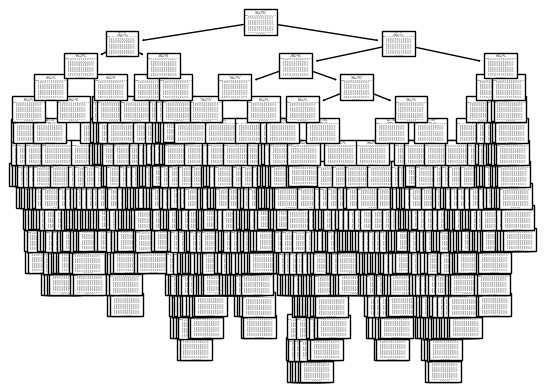

In [40]:
Tshow = tree.plot_tree(Dtree)

In [41]:
y_pred1 = Dtree.predict(X_test)

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
AS_DT = accuracy_score(y_test, y_pred1)
print('DecisionTree accuracy =',AS_DT)

DecisionTree accuracy = 0.01279317697228145


In [44]:
cm = confusion_matrix(y_test,y_pred1)

In [45]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

        9600       0.00      0.00      0.00         1
       10000       0.00      0.00      0.00         3
       10140       0.00      0.00      0.00         1
       10500       0.00      0.00      0.00         1
       10800       0.00      0.00      0.00         1
       10980       0.00      0.00      0.00         1
       11000       0.00      0.00      0.00         2
       11220       0.00      0.00      0.00         1
       11389       0.00      0.00      0.00         1
       11520       0.00      0.00      0.00         1
       11760       0.00      0.00      0.00         1
       12000       0.00      0.00      0.00         3
       12360       0.00      0.00      0.00         0
       12816       0.00      0.00      0.00         0
       12960       0.00      0.00      0.00         0
       12996       0.00      0.00      0.00         1
       13200       0.00      0.00      0.00         2
       13728       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

# LogisticRegression

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
LogR = LogisticRegression()

In [48]:
LogR.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [49]:
y_pred2 = LogR.predict(X_test)

In [50]:
AS_LR = accuracy_score(y_test, y_pred2)
print('LogisticRegression accuracy =',AS_LR)

LogisticRegression accuracy = 0.029850746268656716


In [51]:
cm = confusion_matrix(y_test,y_pred2)


In [52]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

        9600       0.00      0.00      0.00         1
       10000       0.00      0.00      0.00         3
       10140       0.00      0.00      0.00         1
       10500       0.00      0.00      0.00         1
       10800       0.00      0.00      0.00         1
       10980       0.00      0.00      0.00         1
       11000       0.00      0.00      0.00         2
       11220       0.00      0.00      0.00         1
       11389       0.00      0.00      0.00         1
       11520       0.00      0.00      0.00         1
       11760       0.00      0.00      0.00         1
       12000       0.00      0.00      0.00         3
       12996       0.00      0.00      0.00         1
       13200       0.00      0.00      0.00         2
       14400       0.00      0.00      0.00         3
       15000       0.00      0.00      0.00         3
       15120       0.00      0.00      0.00         1
       15360       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###test


In [56]:
from sklearn import metrics

#cnf_matrix = metrics.confusion_matrix(y_test, y_pred2)
#cnf_matrix

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

#class_names=[0,1] # name  of classes
#fig, ax = plt.subplots()
#tick_marks = np.arange(len(class_names))
#plt.xticks(tick_marks, class_names)
#plt.yticks(tick_marks, class_names)
# create heatmap
#sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
#ax.xaxis.set_label_position("top")
#plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
#plt.ylabel('Actual label')
#plt.xlabel('Predicted label')


In [55]:
from sklearn.metrics import classification_report
#target_names = ['A', 'B','C']
#print(classification_report(y_test, y_pred2, target_names=target_names))